In [261]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import islice
import seaborn as sns
from PIL import Image
import requests
from io import BytesIO
import IPython
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Objective
Spot1ny is a project to compare the music tastes of two users based on their Spotify playlists. Features of the playlists such as songs, artists, albums, popularity, and genres will be used to compare the similarities between them. 

I am currently working on the criteria to decide whether or not the two "match". Also, I am building a recomendation system based on the genres and audio features of the playlists. 

# Data acquisition
The playlists are obtained using Spotipy, a library for Spotify's API. Detail codes can be found in the Python files in the same directory.

# Data exploration and preprocessing

In [262]:
# Read files
first_user_df = pd.read_csv("first_user_data.csv", encoding= "utf-8-sig")
second_user_df = pd.read_csv("second_user_data.csv", encoding= "utf-8-sig")
first_user_info_df = pd.read_csv("first_user_info.csv")
second_user_info_df = pd.read_csv("second_user_info.csv")

user1 = str(first_user_info_df["display_name"][0])
user2 = str(second_user_info_df["display_name"][0])

In [263]:
print(len(first_user_df))
print(len(second_user_df))

1294
360


## Dropping duplicate records in the playlists

In [264]:
# Drop duplicate records
first_user_df.drop_duplicates(subset = ["id"], keep = "first", inplace = True)
second_user_df.drop_duplicates(subset = ["id"], keep = "first", inplace = True)

In [265]:
print(len(first_user_df))
print(len(second_user_df))

1123
337


In [266]:
first_user_df.head()

,id,song,artist,album,popularity,duration,img_url,genres
0,2C0sdXFRzSeVERbPYwRocB,目及皆是你 - 心跳版,小蓝背心,目及皆是你,51,175000,https://i.scdn.co/image/ab67616d0000b273cf2696...,['chinese viral pop']
1,2yQSlIvIfRD8pVcNbDhXNw,還是會想你,林達浪,還是會想你,52,190063,https://i.scdn.co/image/ab67616d0000b2734ccb1f...,['chinese viral pop']
2,3xCHPowgMf0ZgXPxXHhUFX,I Love You - 伴奏,汪東城,I Love You (中文版),6,182567,https://i.scdn.co/image/ab67616d0000b2736aec71...,[]
3,08Lw339w7ziPVRVq6B57fo,I Love You - 中文版,汪東城,I Love You (中文版),34,182567,https://i.scdn.co/image/ab67616d0000b2736aec71...,[]
4,4X5SAZ4JKejo2tPhvCJhZf,愛的魔法,金莎,他不愛我,45,191895,https://i.scdn.co/image/ab67616d0000b273d3a256...,"['mainland chinese pop', 'mandopop']"


In [267]:
second_user_df.head()

,id,song,artist,album,popularity,duration,img_url,genres
0,4BHzQ9C00ceJxfG16AlNWb,Send My Love (To Your New Lover),Adele,25,2,223080,https://i.scdn.co/image/ab67616d0000b2734c3bbc...,"['british soul', 'pop', 'pop soul', 'uk pop']"
1,4xqrdfXkTW4T0RauPLv3WA,Heather,Conan Gray,Kid Krow,87,198040,https://i.scdn.co/image/ab67616d0000b27388e3cd...,"['bedroom pop', 'electropop', 'indie pop', 'pop']"
2,0k6LV1ohcK2hlNPwu1nVw9,Cold Heart - Acoustic,Elton John,Cold Heart (Acoustic),66,195373,https://i.scdn.co/image/ab67616d0000b273b4d0d4...,"['glam rock', 'mellow gold', 'piano rock']"
3,5JCoSi02qi3jJeHdZXMmR8,favorite crime,Olivia Rodrigo,SOUR,87,152666,https://i.scdn.co/image/ab67616d0000b273a91c10...,['pop']
4,3WbHsfnKTIpte7B14whqjF,the boy,lullaboy,the boy,54,216530,https://i.scdn.co/image/ab67616d0000b273e608ce...,['chill r&b']


## Visualizations

In [268]:
# Miliseconds to minutes
first_user_df["duration"] = (first_user_df["duration"] * 0.001 / 60).round(2)
second_user_df["duration"] = (second_user_df["duration"] * 0.001 / 60).round(2)

Text(0.5, 1.0, "Average songs' durations")

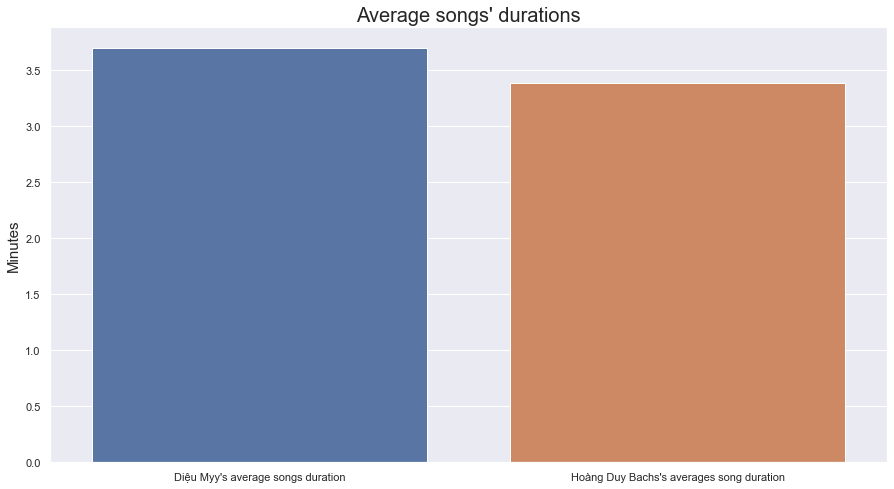

In [269]:
sns.set(rc = {'figure.figsize':(15,8)})
users_durations = [user1 + "'s average songs duration", user2 + "'s averages song duration"]
durations_mean = [first_user_df["duration"].mean(), second_user_df["duration"].mean()]
p = sns.barplot(x= users_durations, y= durations_mean)
p.set_ylabel("Minutes", fontsize = 15)
p.set_title("Average songs' durations", fontsize = 20)

Text(0.5, 1.0, "Average songs' popularity")

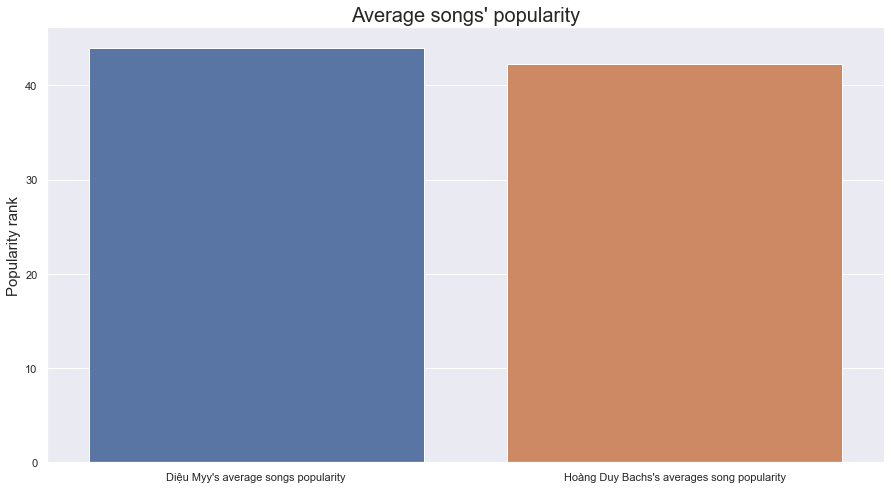

In [270]:
users_popularity = [user1 + "'s average songs popularity", user2 + "'s averages song popularity"]
popularity = [first_user_df["popularity"].mean(), second_user_df["popularity"].mean()]
p = sns.barplot(x= users_popularity, y= popularity)
p.set_ylabel("Popularity rank", fontsize = 15)
p.set_title("Average songs' popularity", fontsize = 20)

In [271]:
def generateDictionary(dataframe, column):
    user_data = []
    if column not in dataframe:
        print("Column doesn't exist")
        return 0
    
    for row in dataframe[column]:
        row_data = row.replace("[","").replace("]","").replace("'","").split(", ")
        if row_data:
            user_data += row_data

    user_data = [i for i in user_data if i]

    user_dict = dict()

    for row in user_data:
        user_dict[row] = user_dict.get(row,0) + 1
    
    return user_dict

In [272]:
def plot(genres_dictionary, user_dataframe, feature):
    user_genres_dict = genres_dictionary
    username = user_dataframe["display_name"][0]
    def take(n, iterable):
        return dict(islice(iterable, n))

    sorted_user_genres =  {k: v for k, v in sorted(user_genres_dict.items(), 
                                                             reverse = True, key=lambda item: item[1])}
    top_10_user_genres = take(10, sorted_user_genres.items())

    p = sns.barplot(x = list(top_10_user_genres.values()), y = list(top_10_user_genres.keys()), orient = "h")
    p.set_xlabel("Count", fontsize = 15)
    p.set_title(username + "'s top " + feature, fontsize = 20)
    
#     plt.barh(list(top_10_user_genres.keys()), top_10_user_genres.values() , align='center')
#     plt.xlabel("Counts")
#     plt.ylabel(feature.capitalize())
#     plt.title(username + "'s top " + feature)
#     plt.show()

In [273]:
first_user_genres_dict = generateDictionary(first_user_df, "genres")
second_user_genres_dict = generateDictionary(second_user_df, "genres")

first_user_artists_dict = generateDictionary(first_user_df, "artist")
second_user_artists_dict = generateDictionary(second_user_df, "artist")

first_user_songs_dict = generateDictionary(first_user_df, "id")
second_user_songs_dict = generateDictionary(second_user_df, "id")

first_user_albums_dict = generateDictionary(first_user_df, "album")
second_user_albums_dict = generateDictionary(second_user_df, "album")

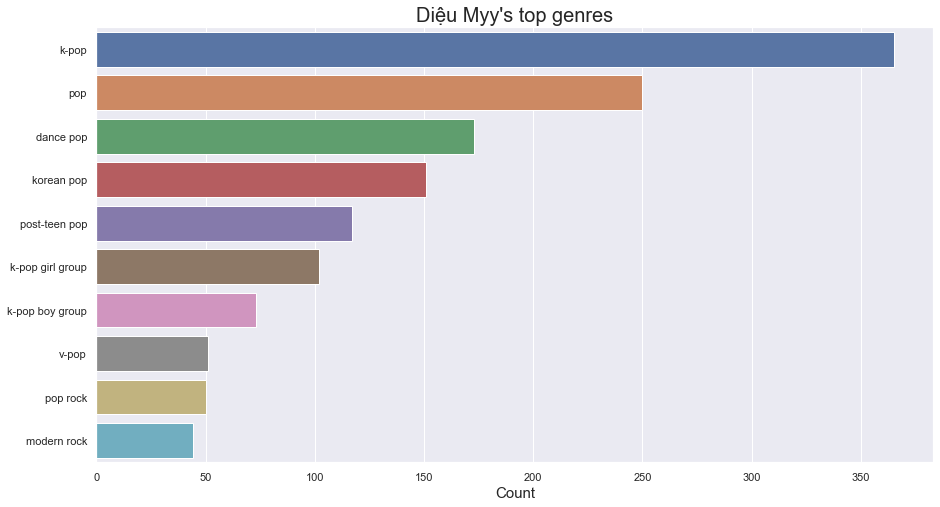

In [274]:
plot(first_user_genres_dict, first_user_info_df, "genres")

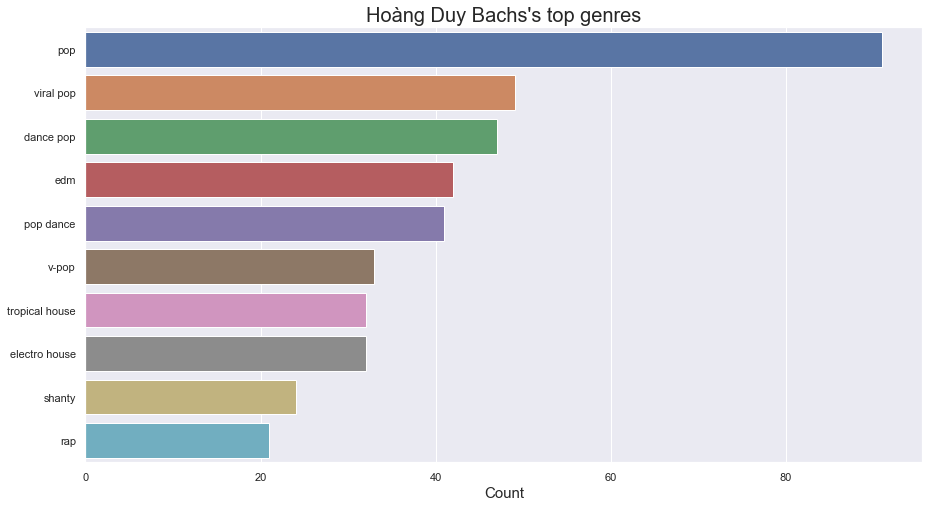

In [275]:
plot(second_user_genres_dict, second_user_info_df, "genres")

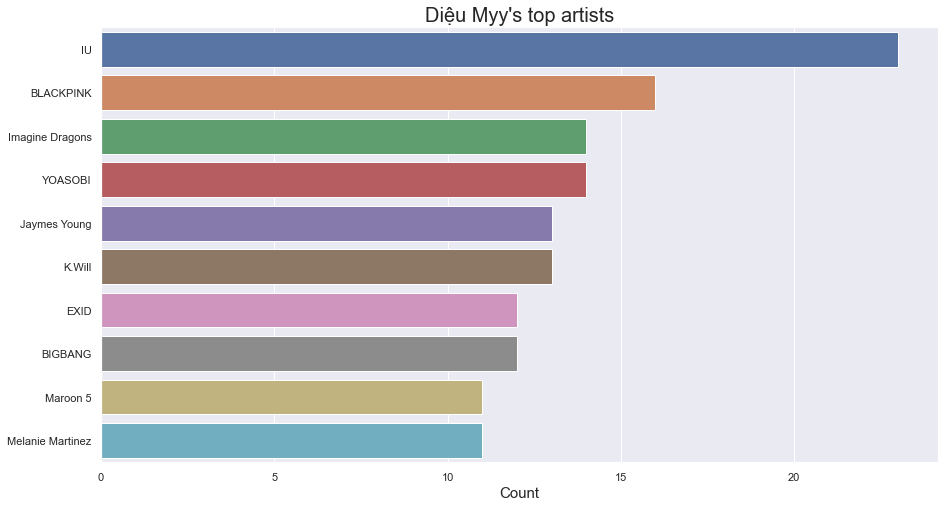

In [276]:
plot(first_user_artists_dict, first_user_info_df, "artists")

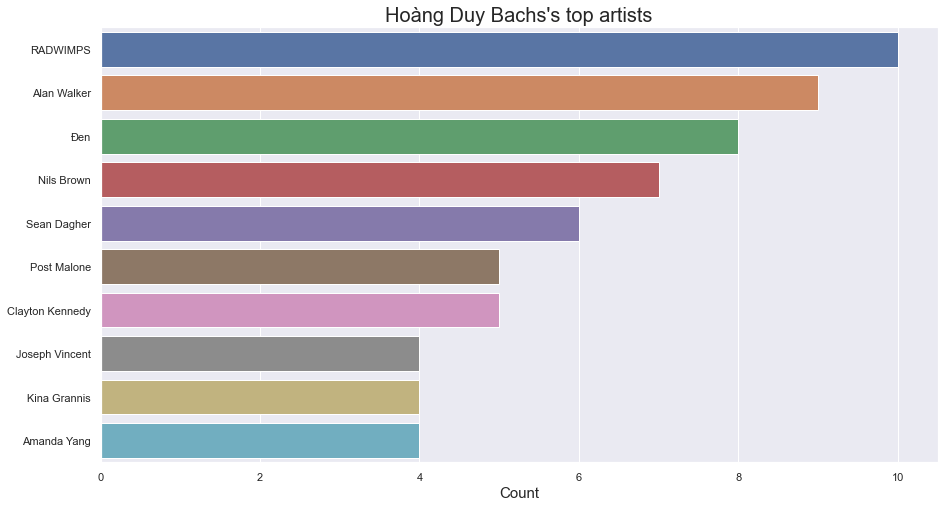

In [277]:
plot(second_user_artists_dict, second_user_info_df, "artists")

C:\Users\truon\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\truon\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\truon\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49436 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\truon\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\truon\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\truon\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 45824 missing from c

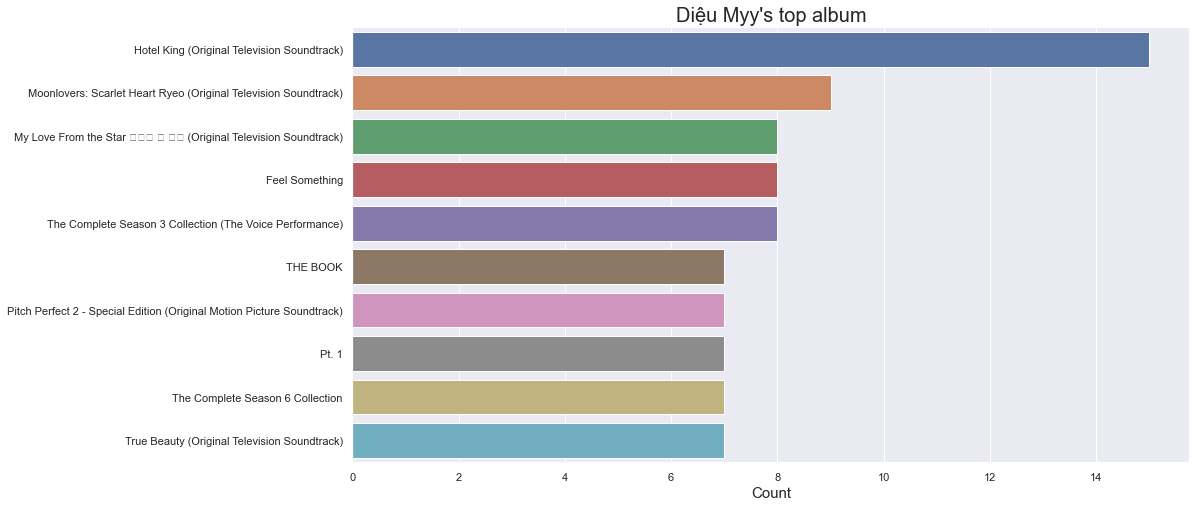

In [278]:
plot(first_user_albums_dict, first_user_info_df, "album")

C:\Users\truon\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 21531 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\truon\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 12398 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\truon\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 21517 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\truon\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 12399 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\truon\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 12290 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\truon\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 21531 missing from c

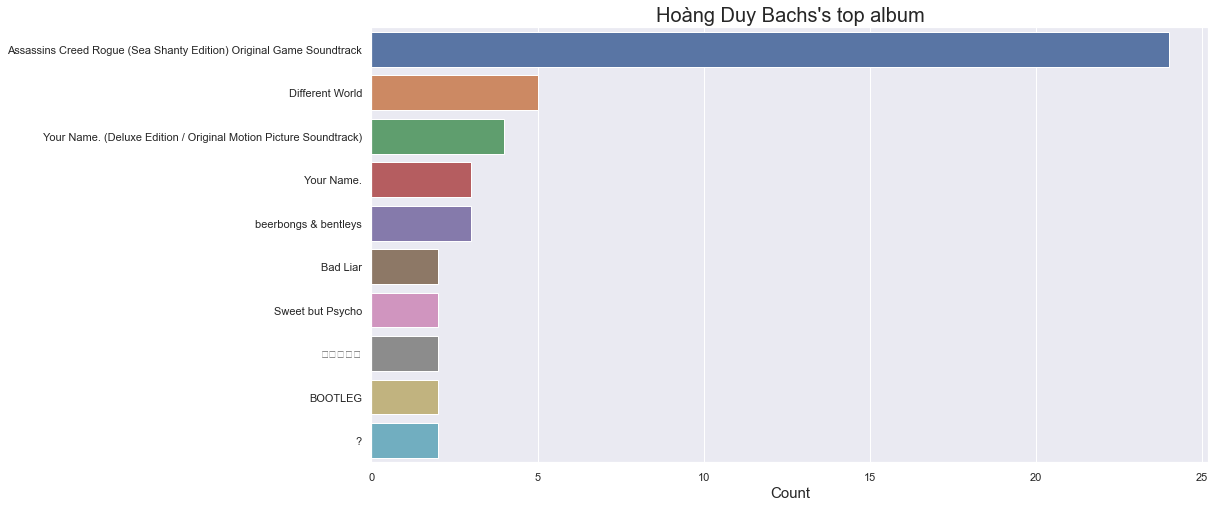

In [279]:
plot(second_user_albums_dict, second_user_info_df, "album")

In [280]:
import requests
from IPython.core.display import Image, display

def featureAnalysis(first_user_dict, second_user_dict, feature):
    first_user_feature = first_user_dict
    second_user_feature = second_user_dict
    
    common_features = dict()
    for key in first_user_feature:
        if key in second_user_feature:
            common_features[key] = min(first_user_feature[key], second_user_feature[key])
    
    if common_features:
        sorted_common_features =  {k: v for k, v in sorted(common_features.items(), 
                                                             reverse = True, key=lambda item: item[1])}
        
        keys = []
        counts = []
        print("Most common " + feature + ":")
        for i,key in enumerate(sorted_common_features):
            if i == 5: break
            if feature == "songs":
                song = first_user_df.loc[first_user_df["id"]==key].values[0]
                print(song[1] + " by " + song[2] + " in " + song[3])
                display(Image(url=song[6], width=300, height=300))
            else:
                print(key, sorted_common_features[key])
                keys.append(key)
                counts.append(sorted_common_features[key])
                p = sns.barplot(x = counts, y = keys, orient = "h")
                p.set_xlabel("Count", fontsize = 15)
                p.set_title("Common "  + feature, fontsize = 20)
      
    else:
        print("No common " + feature)
        
#     score = len(set(first_) & set(test_list2)) / float(len(set(test_list1) | set(test_list2))) * 100

In [281]:
featureAnalysis(first_user_songs_dict, second_user_songs_dict, "songs")

Most common songs:
Runaway by AURORA in All My Demons Greeting Me as a Friend (Deluxe)


Hymn for the Weekend by Coldplay in A Head Full of Dreams


シルエット by KANA-BOON in Time


Stay With Me by CHANYEOL in Guardian (Original Television Soundtrack), Pt. 1


Can’t Help Falling in Love by Kina Grannis in Crazy Rich Asians (Original Motion Picture Soundtrack)


Most common genres:
pop 91
dance pop 47
viral pop 43
v-pop 33
j-pop 19


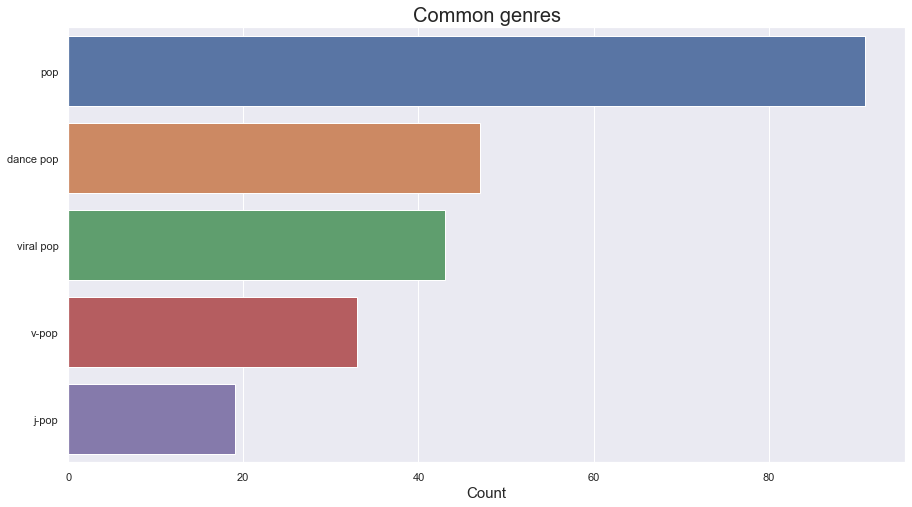

In [282]:
featureAnalysis(first_user_genres_dict, second_user_genres_dict, "genres")

Most common artists:
Alan Walker 7
Coldplay 2
Avicii 2
AURORA 1
Maroon 5 1


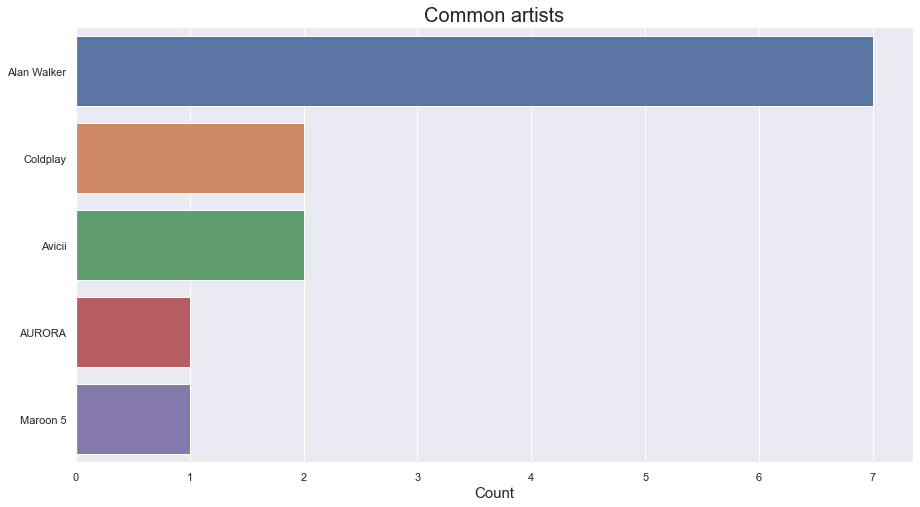

In [283]:
featureAnalysis(first_user_artists_dict, second_user_artists_dict, "artists")

In [284]:
def popularityAnalysis(first_dataframe, first_user_info_df, second_dataframe, second_user_info_df):
    print(first_user_info_df["display_name"][0] + "'s average songs' popularity is", first_dataframe["popularity"].mean())
    print(second_user_info_df["display_name"][0] + "'s average songs' popularity is", second_dataframe["popularity"].mean())
    print("\n")
    
    max_first_pop = first_dataframe.sort_values(by=["popularity"]).iloc[-1]
    min_first_pop = first_dataframe.sort_values(by=["popularity"]).iloc[0]
    
    print(first_user_info_df["display_name"][0] + "'s most and least popular songs are")                                                
    print(max_first_pop["song"] + " by " + max_first_pop["artist"] + " with popularity " + str(max_first_pop["popularity"]))
    print(min_first_pop["song"] + " by " + min_first_pop["artist"] + " with popularity " + str(min_first_pop["popularity"]))
    print("\n")
    max_second_pop = second_dataframe.sort_values(by=["popularity"]).iloc[-1]
    min_second_pop = second_dataframe.sort_values(by=["popularity"]).iloc[0]
    
    print(second_user_info_df["display_name"][0] + "'s most and least popular songs are")
    print(max_second_pop["song"] + " by " + max_second_pop["artist"] + " with popularity " + str(max_second_pop["popularity"]))
    print(min_second_pop["song"] + " by " + min_second_pop["artist"] + " with popularity " + str(min_second_pop["popularity"]))

In [285]:
popularityAnalysis(first_user_df, first_user_info_df, second_user_df, second_user_info_df)

Diệu Myy's average songs' popularity is 43.94924309884239
Hoàng Duy Bachs's average songs' popularity is 42.231454005934715


Diệu Myy's most and least popular songs are
STAY (with Justin Bieber) by The Kid LAROI with popularity 93
어느 봄날 One Spring Day by 2am with popularity 0


Hoàng Duy Bachs's most and least popular songs are
Heather by Conan Gray with popularity 87
Người Âm Phủ by Osad with popularity 0


In [286]:
def similarityAnalysis(first_user_df, first_user_info_df, second_user_df, second_user_info_df, feature):
    if feature == "song":
        feature = "id"
    
    if feature == "genres":
        u1 = first_user_df[feature].to_numpy()
        u2 = second_user_df[feature].to_numpy()
        u1_set = set()
        u2_set = set()
        for item in u1:
            item = item.replace("[","").replace("]","").replace("'","").split(", ")
            for genre in item:
                u1_set.add(genre)
        for item in u2:
            item = item.replace("[","").replace("]","").replace("'","").split(", ")
            for genre in item:
                u2_set.add(genre)
                
        similarity = len(set(u1_set) & set(u2_set))/len(set(u1_set) | set(u2_set))*100
    
    else:
        u1 = first_user_df[feature]
        u2 = second_user_df[feature]
        u1.drop_duplicates(keep = "first", inplace = True)
        u2.drop_duplicates(keep = "first", inplace = True)
        similarity = len(pd.merge(u1, u2, how = "inner").index)/len(pd.merge(u1, u2, how = "outer").index)*100
    
    return similarity


In [287]:
print("Songs similarity",similarityAnalysis(first_user_df, first_user_info_df, second_user_df, second_user_info_df, "song"),"%")
print("Aritsts similarity", similarityAnalysis(first_user_df, first_user_info_df, second_user_df, second_user_info_df, "artist"), "%")
print("Albums similarity", similarityAnalysis(first_user_df, first_user_info_df, second_user_df, second_user_info_df, "album"), "%")
print("Popularity similarity", similarityAnalysis(first_user_df, first_user_info_df, second_user_df, second_user_info_df, "popularity"), '%')
print("Genres similiarity", similarityAnalysis(first_user_df, first_user_info_df, second_user_df, second_user_info_df, "genres"), "%")

Songs similarity 1.0380622837370241 %
Aritsts similarity 6.811989100817439 %
Albums similarity 1.6536118363794605 %
Popularity similarity 92.22222222222223 %
Genres similiarity 28.969359331476323 %


## ... Recommendation System in progress ...

In [288]:
def toList(x):
    return x.replace(" ", "").replace("'","").replace("[","").replace("]","").split(",")
first_user_df["genres"] = first_user_df["genres"].apply(clean_data)
first_user_df["genres"]

0                          [chineseviralpop]
1                          [chineseviralpop]
2                                         []
3                                         []
4             [mainlandchinesepop, mandopop]
                        ...                 
1289               [v-pop, vietnamesehiphop]
1290    [v-pop, vietnamesesinger-songwriter]
1291        [indonesianpop, javanesedangdut]
1292                [j-pop, japaneseteenpop]
1293              [idolrock, j-popgirlgroup]
Name: genres, Length: 1123, dtype: object

In [289]:
type(first_user_df["genres"][0])

list

In [290]:
def mergeList(x):
    return ' '.join(x['genres'])

In [291]:
first_user_df["genres"] = first_user_df.apply(create_soup, axis=1)
first_user_df["genres"]

0                         chineseviralpop
1                         chineseviralpop
2                                        
3                                        
4             mainlandchinesepop mandopop
                      ...                
1289               v-pop vietnamesehiphop
1290    v-pop vietnamesesinger-songwriter
1291        indonesianpop javanesedangdut
1292                j-pop japaneseteenpop
1293              idolrock j-popgirlgroup
Name: genres, Length: 1123, dtype: object

Datacamp reference/ I'm working on a way to embed the audio features in

In [292]:
count = CountVectorizer()
count_matrix = count.fit_transform(first_user_df["genres"])

In [293]:
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)
first_user_df = first_user_df.reset_index()
indices = pd.Series(first_user_df.index, index=first_user_df['song'])

In [294]:
def get_recommendations(title, cosine_sim=cosine_sim2):
    
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    song_indices = [i[0] for i in sim_scores]
    
    return first_user_df['song'].iloc[song_indices]

In [295]:
get_recommendations('Dead And Gone', cosine_sim2)

612                                    Whatever You Like
626                                    Don't Let Me Fall
746                   See You Again (feat. Charlie Puth)
885        Airplanes (feat. Hayley Williams of Paramore)
577                                         Just A Dream
218    Bellas Regionals: The Sign/Eternal Flame/Turn ...
368                    Next To You (feat. Justin Bieber)
789                    Stereo Hearts (feat. Adam Levine)
353                                      I Need A Doctor
379                                          The Monster
Name: song, dtype: object